<a href="https://colab.research.google.com/github/amirhoseinoveis/LIME_with_MSTAR/blob/main/LIME_with_MSTAR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Let's import the necessary libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import os


**You can download the MSTAR database - only 3 classes for this example - from my GitHub page**

In [ ]:
github_url = 'https://raw.githubusercontent.com/amirhoseinoveis/LIME_with_MSTAR/7f0ea0868eec651540c373570060728392070ff5/mstar_3cl_32by32.npz'

# Download the file using wget
path = '/content/mstar_3cl_32by32.npz'
os.system(f'wget {github_url} -O {path}')

# Load the data using np.load
with np.load(path) as data_mstar:
    x_train_mstar = data_mstar['x_train']
    y_train_mstar = data_mstar['y_train']
    x_test_mstar = data_mstar['x_test']
    y_test_mstar = data_mstar['y_test']
x_train_mstar=np.concatenate([x_train_mstar,x_train_mstar,x_train_mstar],axis=-1)
x_test_mstar=np.concatenate([x_test_mstar,x_test_mstar,x_test_mstar],axis=-1)


**Let’s define a very simple CNN using the Tensorflow.keras library as**





In [ ]:

inputs = Input(shape=(32,32,3),name="Input")
x = Conv2D(32, 3, activation="relu", padding='same',name='Conv1')(inputs)
x = MaxPooling2D(2,name='Pool1')(x)
x = Conv2D(16, 3, activation="relu",padding='same',name='Conv2')(x)
x = MaxPooling2D(2,name='Pool2')(x)
x = Flatten(name='Vectorize')(x)
x= Dense(3,name='FC')(x)
outputs= Activation("softmax",name='Softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()


**Now we train the model by the training database.**

In [ ]:

hist = model.fit(
x_train_mstar,
to_categorical(y_train_mstar, 3),  # One-hot encode your labels
batch_size=32,
epochs=10,
validation_split=0.15,
shuffle='on',
)


**We can visulize the training process over different epochs**

In [ ]:

plt.figure(1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.grid("on")
plt.show()

plt.figure(3)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.grid("on")
plt.show()


**After training, the network can predict the class of the test database:**

In [ ]:
classes_in=[0,1,2]
y_hat=model.predict(x_test_mstar)#test the model, prob.

y_hat_cl=y_hat.argmax(1) #prob. to class
CM=np.zeros([len(classes_in),len(classes_in)])# Confusion matrix,
for k in range(y_test_mstar.shape[0]):
    CM[y_test_mstar[k],y_hat_cl[k]]=CM[y_test_mstar[k],y_hat_cl[k]]+1

# Display confusion matrix
print("Confusion Matrix:")
for i in range(len(classes_in)):
    row_str = "| "
    for j in range(len(classes_in)):
        row_str += f"{int(CM[i, j]):>4} | "
    print(row_str)
print('Acc=',np.sum(y_hat_cl==y_test_mstar)/y_test_mstar.shape[0])



**Now Install LIME and Import the necessary libraries**

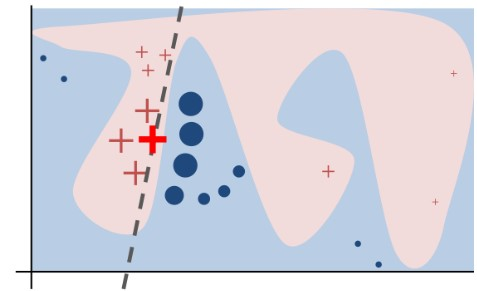

In [ ]:
pip install lime

In [ ]:
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

**We should define segmentation algorithm!**

**For that we can use slic (simple linear iterative clustering)**

In [ ]:
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)
# segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
# segmenter = SegmentationAlgorithm('felzenszwalb',scale= 10, sigma= 0.4, min_size=50)

**n_segments indicates the number of superpixels. It means that a larger n_segments will result in smaller supepixels**

**We can then use the pre-trained model and a test image (the 600th image, which belongs to class 2).**

**LIME produces one output image**

In [ ]:
ind=[600]
test_img=x_test_mstar[ind][0]
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(test_img,
                                         classifier_fn = model.predict,
                                         top_labels=1, hide_color=0, num_samples=5000, segmentation_fn=segmenter)

In [ ]:
y_hat[600]

**By using a large num_samples in the above code, 5000, the results is more robust and reliable.**

**Now we visualize the main superpixel that favors the top class**

In [ ]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                 positive_only=False,
                                 num_features=1,
                                 hide_rest=False,
                                 min_weight=0
                                )
plt.imshow(mark_boundaries(image, mask))
plt.axis('off')
plt.show()

**num_features=1 in the above code means that only one superpixel is shown.**

**We can see the results with different** *num_features*


In [ ]:
for i in range (1,5):
    image, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                 positive_only=False,
                                 num_features=i,
                                 hide_rest=False,
                                 min_weight=0
                                )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()



**Green superpixels have postive contributions to the prediction (class2) while red ones have negative contribution.**

 **Let's have another experiment. We can increase the number of features, superpixels, for example from 100 to 500, and see the results.**

In [ ]:
segmenter = SegmentationAlgorithm('slic', n_segments=500, compactness=1, sigma=1)
ind=[600]
test_img=x_test_mstar[ind][0]
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(test_img,
                                         classifier_fn = model.predict,
                                         top_labels=1, hide_color=0, num_samples=5000, segmentation_fn=segmenter)


In [ ]:
for i in range (1,20):
    image, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                 positive_only=False,
                                 num_features=i,
                                 hide_rest=False,
                                 min_weight=0
                                )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

**We can see that by increasing the number of superpixels (to 500) each superpixel becomes smaller. Moreover, by using an increased number of superpixels (up to 20), still the target area is influencing the model's output**